In [1]:
# Setup of libraries, mounting the Google Drive etc.

local = True

import os

if local == False:
    import sys
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir('/content/gdrive/My Drive/Colab Notebooks')
else:
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf

import utils
import IPython

print('The current working directory is:', os.getcwd())

The current working directory is: /Users/jankaiser/Documents/TUHH/Research Project/Auswertung/machine_learning


## Define the parameters
... meaning paramters like which dataset to train on, batch size and so on and so forth

In [2]:
DATASET_NAME = 'cabspotting'
GRU_SIZE = 32

setup_string = 'GRU-{gru_size}_TD-Dense-3_{dataset}_64_100_adam_mae_default'.format(dataset=DATASET_NAME,
                                                                                    gru_size=GRU_SIZE)

In [3]:
setup_string

'GRU-32_TD-Dense-3_cabspotting_64_100_adam_mae_default'

## Read the dataset from `.pkl` file


In [4]:
df = pd.read_pickle('datasets/{name}.pkl'.format(name=DATASET_NAME))
df.head()

latitude  longitude  occupied
user   time                                              
abboip 2008-05-17 14:12:10  37.75153 -122.39447         0
       2008-05-17 14:13:34  37.75149 -122.39447         0
       2008-05-17 14:14:34  37.75149 -122.39447         0
       2008-05-17 14:15:35  37.75149 -122.39446         0
       2008-05-17 14:41:43  37.75144 -122.39449         0

## Convert the dataset to a mapping of users to the strings of their movements

In [5]:
df = utils.records_to_user_geolcation_2(df)
df.head()

user
abboip      [[0.0, -122.39447, 37.751529999999995], [84.0,...
abcoij      [[0.0, -122.41466000000001, 37.80346], [60.000...
abdremlu    [[0.0, -122.39093000000001, 37.75521], [60.000...
abgibo      [[0.0, -122.4374, 37.7733], [45.0, -122.43834,...
abjoolaw    [[0.0, -122.39747, 37.75159], [60.000000000000...
dtype: object

## Concatenate all user strings of data to one complete string of all

In [6]:
data = utils.user_geolocation_to_single_sequence(df)

print(data.shape)
print()
print(data)

(11219955, 3)

[[   0.      -122.39447   37.75153]
 [  84.      -122.39447   37.75149]
 [  60.      -122.39447   37.75149]
 ...
 [  64.      -122.44239   37.75686]
 [  56.      -122.44215   37.76047]
 [  61.      -122.43687   37.76075]]


## Convert the data to 32-bit floats
This is to correct an error I got earlier. Apparently the GRU layers can't handle 64-bit integers (doubles) as input.

In [7]:
print('Before: ', data.dtype)

Before:  float64


In [8]:
data = data.astype(np.float32)

In [9]:
print('After: ', data.dtype)

After:  float32


## Reshape and -order the data for input into the model (including X and y split)


In [10]:
data.shape

(11219955, 3)

In [11]:
BATCH_SIZE = 64
SEQ_LENGTH = 100

n_batches, X, y = utils.reshape_single_sequence_to_rnn_Xy(data, BATCH_SIZE, SEQ_LENGTH)

print('X:', X.shape)
print('y:', y.shape)

X: (112192, 100, 3)
y: (112192, 100, 3)


## Split into training and validations sets

In [12]:
n_train = int(n_batches * 0.8) * BATCH_SIZE
X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:]
y_val = y[n_train:]

print('Train:', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)

Train: (89728, 100, 3) (89728, 100, 3)
Validation: (22464, 100, 3) (22464, 100, 3)


## Standardisation
All three features in the data are scaled to have a `mean = 0` and a `standard deviation = 1`.

The Scaler is also saved to disk, so it can later be resued in a different Notebook.

The Scaler is fitted only to the training data, not the validation / test data.

In [13]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(np.array([X_train[:, :, 0].reshape(-1), X_train[:, :, 1].reshape(-1), X_train[:, :, 2].reshape(-1)]).transpose())

print('Means: %f %f %f' % (scaler.mean_[0], scaler.mean_[1], scaler.mean_[2]))
print('Standard deviations: %f %f %f' % (scaler.var_[0], scaler.var_[1], scaler.var_[2]))

Means: 91.854850 -122.412297 37.763381
Standard deviations: 2743421.750000 0.001298 0.002889


In [14]:
with open('scalers/citybased_rnn_2/' + setup_string + '.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    print('Scaler saved')

FileNotFoundError: [Errno 2] No such file or directory: 'scalers/citybased_rnn_2/GRU-32_TD-Dense-3_cabspotting_64_100_adam_mae_default.pkl'

In [15]:
for i in range(len(X_train)):
    X_train[i] = scaler.transform(X_train[i])
    y_train[i] = scaler.transform(y_train[i])

for i in range(len(X_val)):
    X_val[i] = scaler.transform(X_val[i])
    y_val[i] = scaler.transform(y_val[i])

In [16]:
print(X_train.shape)
print()
print(X_train[:1, :6])
print(X_val[:1, :6])

(89728, 100, 3)

[[[-0.05545693  0.49488014 -0.22048947]
  [-0.00474233  0.49488014 -0.2211992 ]
  [-0.01923221  0.49488014 -0.2211992 ]
  [-0.01862847  0.49509194 -0.2211992 ]
  [ 0.89121556  0.49424475 -0.22219281]
  [-0.01259102  0.49318576 -0.22084434]]]
[[[-0.02104345  2.7541401   1.1455052 ]
  [-0.01862847  2.7359254   1.1438019 ]
  [-0.01802472  2.4103904   1.0920634 ]
  [ 0.03872733  1.1872511   0.7922075 ]
  [-0.02828839  0.88247234  0.6001577 ]
  [-0.02768465  0.55714905  0.4087467 ]]]


## Build the model

In [17]:
def build_model(batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(GRU_SIZE, return_sequences=True, stateful=True, input_shape=(None, 3), batch_size=batch_size),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3))
    ])
    return model

In [18]:
model = build_model(batch_size=BATCH_SIZE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (64, None, 32)            3456      
_________________________________________________________________
time_distributed (TimeDistri (64, None, 3)             99        
Total params: 3,555
Trainable params: 3,555
Non-trainable params: 0
_________________________________________________________________


In [19]:
tf.keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

## Test the model's output (before training)

In [19]:
model.input

<tf.Tensor 'gru_input:0' shape=(64, ?, 3) dtype=float32>

In [20]:
# Test the shape of the output
test_batch = X[:BATCH_SIZE]
print('Input batch:', test_batch.shape)
test_predictions = model.predict(test_batch, batch_size=BATCH_SIZE)

print('Output batch:', test_predictions.shape)

model.reset_states()

Input batch: (64, 100, 3)
Output batch: (64, 100, 3)


In [21]:
test_batch = scaler.inverse_transform(test_batch)
test_predictions = scaler.inverse_transform(test_predictions)

In [22]:
print('Input: \n', test_batch[0, 0], test_batch[0, 1], test_batch[0, 2], '...')
print()
print('Next Predictions: \n', test_predictions[0, 0], test_predictions[0, 1], test_predictions[0, 2], '...')

Input: 
 [-5.5506291e-07 -1.2239447e+02  3.7751530e+01] [  84.      -122.39447   37.75149] [  60.      -122.39447   37.75149] ...

Next Predictions: 
 [ 153.29369 -122.41397   37.76115] [ 186.65732 -122.41483   37.76019] [ 202.27655  -122.41527    37.759506] ...


## Training

In [23]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [24]:
# Folder for the architecture
# Name: List of the layers connected to the parameters by '-',
#       dataset that the network was trained on,
#       batch size,
#       sequence length,
#       optimiser,
#       loss function,
#       learning rate,
#       epoch the checkpoint is from
checkpoint_path = 'checkpoints/citybased_rnn_2/' + setup_string + '_{epoch:02d}.h5'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)

In [25]:
hist = model.fit(X_train, y_train, epochs=30, batch_size=BATCH_SIZE, shuffle=False, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Train on 89728 samples, validate on 22464 samples
Epoch 1/30
29888/89728 [========>.....................] - ETA: 1:54 - loss: 0.1033

KeyboardInterrupt: 

## Save and plot the history
The history holds information on loss and validiation loss during training.

In [27]:
with open('histories/citybased_rnn_2/' + setup_string + '_30.pkl', 'wb') as file:
    pickle.dump(hist.history, file)
    print('History saved')

History saved


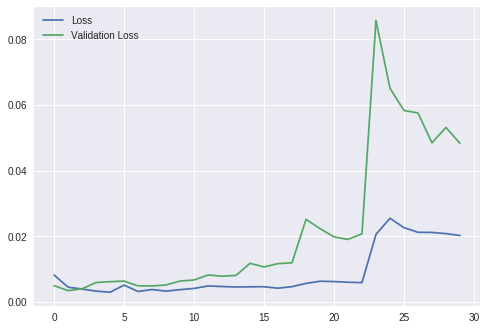

In [28]:
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## Load and prepare the trained model for generating data

In [0]:
loaded_model = tf.keras.models.load_model('checkpoints/citybased_rnn_2/GRU-1024_TD-Dense-3_cabspotting_64_100_adam_mae_default_05.h5')

In [0]:
model = build_model(batch_size=1)

weights = loaded_model.get_weights()
model.set_weights(weights)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, None, 1024)           3158016   
_________________________________________________________________
time_distributed_1 (TimeDist (1, None, 3)              3075      
Total params: 3,161,091
Trainable params: 3,161,091
Non-trainable params: 0
_________________________________________________________________


## Generate geolocation data of one entity using the trained model
In the end the generated data is saved to disk in order to be reused from a different notebook.

In [0]:
N_GENERATE = 1000

start = [324.0, -122.390085, 37.789910]    # Google Offices in San Francisco: 37.789910, -122.390085
generated = np.array([start]).astype(np.float32)

model.reset_states()

for i in range(1, N_GENERATE):
    input = generated[-1:]
    input = scaler.transform(input)
    input = np.array([input])
    
    prediction = model.predict(input, batch_size=1)
    
    prediction = np.squeeze(prediction, axis=0)
    prediction = scaler.inverse_transform(prediction)
    
    generated = np.concatenate([generated, prediction])

In [0]:
generated.shape

(1000, 3)

In [0]:
generated

array([[ 3.24000000e+02, -1.22390083e+02,  3.77899094e+01],
       [-3.02492656e+04, -1.22387428e+02,  3.77959785e+01],
       [-5.41318281e+04, -1.22385445e+02,  3.78016281e+01],
       ...,
       [-1.29628850e+06, -1.22439728e+02,  3.76924286e+01],
       [-1.29628400e+06, -1.22439728e+02,  3.76924057e+01],
       [-1.29627975e+06, -1.22439728e+02,  3.76923828e+01]], dtype=float32)

In [0]:
with open('generated/citybased_rnn_2/test_00.pkl', 'wb') as file:
    pickle.dump(generated, file)
    print('Generated data saved')

Generated data saved
